In [1]:
import time
import re, ast
import numpy as np
import os
import pandas as pd
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils

os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("KafkaReceive") \
    .getOrCreate()

In [3]:
from sklearn.cluster import KMeans
locs = pd.read_csv("../../data/mote_locs.txt", header=None, sep=" ")
locs.columns = ["SensorId", "X", "Y"]
ids = locs.values[:, 0]
pos = locs.values[:, 1:]

kmeans = KMeans(n_clusters=5, random_state=0).fit(pos)
labels = np.vstack((ids, kmeans.labels_)).T.astype(int)
clusters = pd.DataFrame({'SensorId': labels[:,0], 'ClusterId': labels[:,1]})

clusters.loc[clusters.SensorId==1].ClusterId

0    2
Name: ClusterId, dtype: int64

In [4]:
# sensor to predict
sensors_to_predict = [1, 24]
target_cluster = clusters[clusters.SensorId.isin(sensors_to_predict)]
print(target_cluster)

    ClusterId  SensorId
0           2         1
23          4        24


In [5]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='persistence',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "zoo1:2181,zoo2:2181,zoo3:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]

In [6]:
#Save state in global Python variable
def saveState(rdd):
    global state_global
    if rdd is not None:
        data=rdd.collect()
        state_global.append(data)
        
def printInfoRDD(rdd):
    #clear_output(wait=True)
    if rdd is not None:
        print("The RDD has "+str(rdd.getNumPartitions())+" partitions")
        print("The RDD has "+str(rdd.count())+" elements")
    else:
        print("No info to provide")

In [11]:
def updateEMA(new_value, state):
    # new_value = (x, y_true, time_y, y_id) where x in avg temp in cluster
    # state = (alpha, EMA, MSSE, N, err2, y_true, y_time, y_id)
    if len(new_value) > 0:
        x = new_value[0][0]
        y_true = new_value[0][1]
        y_time = new_value[0][2]
        y_id = new_value[0][3]
        
        alpha = state[0]
        EMA = state[1]
        EMA = alpha*x + (1-alpha)*EMA # exp. moving avg
        N = state[3]
        SSE = state[2] * N
        try:
            err = y_true - EMA      
            SSE = SSE + pow(err,2)
            N += 1
        except TypeError:
            print('y_true is not valid type')
            
        return (alpha, EMA, SSE/N, N, err**2, y_true, y_time, y_id)
    else:
        return state

In [24]:
import requests

OPENTSDB_URL = 'http://' + os.environ.get('OPENTSDB_URL') #"http://localhost:4242"
print(OPENTSDB_URL)

def sendPartition(iter):
    print("Sending the partition")
    print(iter.collect())
    if iter:
        r = requests.post(OPENTSDB_URL + '/api/put', data=json.dumps(iter.collect()[0]))
        print(r.status_code)
        return r.status_code
    else:
        r = 400
        print(r)
        return r

http://opentsdb:4242
Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}], [{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}]]
400
Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0

In [26]:
import re, ast
import json

#Batch interval (to be synchronized with KafkaSend)
interval = 1
time_resolution = 30
simulation = 1

# state = (alpha, EMA, MSSE, N, err2, y_true, y_time, y_id)
alpha1 = 0.2
cluster1 = int(clusters.loc[clusters.SensorId==1].ClusterId)
state1 = (alpha1,20,0,0,0,20,0,1)

alpha24 = 0.2
cluster24 = int(clusters.loc[clusters.SensorId==24].ClusterId)
state24 = (alpha24,20,0,0,0,20,0,24)

state_global = []

# dstream value format: y_id, time_y, y_true, x_Value, x_seconds, x_SensorId, x_Type)
if simulation:
    [sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='ClusterRLSTrain',batch_interval=interval)
    dstream = dstream.map(lambda x: json.loads(x[1]))
else:
    [sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='ClusterRLSTrain',batch_interval=time_resolution)
    dstream = dstream.map(lambda x: json.loads(x[1]))\
                     .window(time_resolution, time_resolution)

# dstream value format: (ClusterId, (y_id, time_y, y_true, x_Value, x_seconds, x_SensorId, x_Type)):
dstream = dstream.map(lambda x: (int(clusters.loc[clusters.SensorId==int(x[5])].ClusterId), x))
# keep only data belonging to target_cluster_id:
dstream = dstream.filter(lambda x: x[0] == int(target_cluster[target_cluster.SensorId==x[1][0]].ClusterId))
dstream = dstream.mapValues(lambda x: (x[3], 1, x[2], x[1], x[0])) # (x, 1, y_true, time_y, y_id)
# compute average of x:
dstream = dstream.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2], x[3], x[4]))
dstream = dstream.mapValues(lambda x: (x[0]/x[1], x[2], x[3], x[4])) # (x, y_true, time_y, y_id)

initialStateRDD = sc.parallelize([(cluster1, state1),
                                  (cluster24, state24)])
dstream = dstream.updateStateByKey(updateEMA, initialRDD=initialStateRDD)

stateStream = dstream.map(lambda x: [{'metric': 'temperature.prediction',
                                           'timestamp': x[1][-2],
                                           'value': x[1][1],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}},
                                           {'metric': 'temperature.truth',
                                           'timestamp': x[1][-2],
                                           'value': x[1][5],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}},
                                           {'metric': 'temperature.error',
                                           'timestamp': x[1][-2],
                                           'value': x[1][4],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}}
                                     ])


#dstream.pprint()
#dstream.foreachRDD(saveState)
#stateStream.pprint()
stateStream.foreachRDD(sendPartition)

In [27]:
ssc.start()
ssc.awaitTermination()

Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}], [{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}]]
400


Py4JJavaError: An error occurred while calling o47641.awaitTermination.
: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/usr/local/spark-2.2.1/python/pyspark/streaming/util.py", line 67, in call
    return r._jrdd
AttributeError: 'int' object has no attribute '_jrdd'

	at org.apache.spark.streaming.api.python.TransformFunction.callPythonTransformFunction(PythonDStream.scala:95)
	at org.apache.spark.streaming.api.python.TransformFunction.apply(PythonDStream.scala:78)
	at org.apache.spark.streaming.api.python.PythonDStream$$anonfun$callForeachRDD$1.apply(PythonDStream.scala:179)
	at org.apache.spark.streaming.api.python.PythonDStream$$anonfun$callForeachRDD$1.apply(PythonDStream.scala:179)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ForEachDStream.scala:51)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1$$anonfun$apply$mcV$sp$1.apply(ForEachDStream.scala:51)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1$$anonfun$apply$mcV$sp$1.apply(ForEachDStream.scala:51)
	at org.apache.spark.streaming.dstream.DStream.createRDDWithLocalProperties(DStream.scala:416)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1.apply$mcV$sp(ForEachDStream.scala:50)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1.apply(ForEachDStream.scala:50)
	at org.apache.spark.streaming.dstream.ForEachDStream$$anonfun$1.apply(ForEachDStream.scala:50)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.streaming.scheduler.Job.run(Job.scala:39)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler$$anonfun$run$1.apply$mcV$sp(JobScheduler.scala:257)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler$$anonfun$run$1.apply(JobScheduler.scala:257)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler$$anonfun$run$1.apply(JobScheduler.scala:257)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:58)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler.run(JobScheduler.scala:256)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}], [{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}]]
400
Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags'

In [28]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

Sending the partition
[[{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 24, 'municipality': 4, 'city': 'Brussels'}}], [{'metric': 'temperature.prediction', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.truth', 'timestamp': 0, 'value': 20, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}, {'metric': 'temperature.error', 'timestamp': 0, 'value': 0, 'tags': {'space': 1, 'municipality': 2, 'city': 'Brussels'}}]]
400


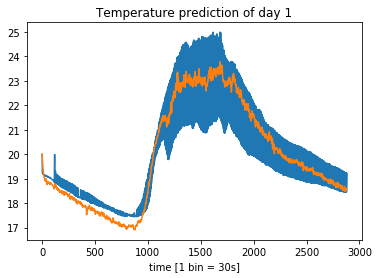

MSE =  0.734356002642


In [14]:
yhat = []
ytrue = []
time = []
err2 = []
for rdd in state_global:
    for pred in rdd:
        alpha, EMA, MSSE, N, err_2, y_true, bin = pred[1]
        yhat.append(EMA)
        ytrue.append(y_true)
        time.append(bin)
        err2.append(err_2)

import matplotlib.pyplot as plt

time = np.array(time)
yhat = np.array(yhat)
ytrue = np.array(ytrue)
err2 = np.array(err2)

fig1, ax1 = plt.subplots()
ax1.plot(time, ytrue)
ax1.set_title("Temperature prediction of day 1")
ax1.set_xlabel("time [1 bin = 30s]")

ax1.plot(time, yhat)
#ax1.plot(time, err2)
plt.show()

print('MSE = ', np.mean(err2))


array([0, 0, 0, 0, 0, 0, 0])